In [1]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
path_suppinf = PATHPLOT / Path(PATHNPAPR, 'suppinf')
path_extras = path_suppinf / Path('extras')
path_isingXERR = path_extras / Path('isingXERR')
path_tsb = path_extras / Path('tsb')
sub_path = Path(*path_tsb.parts[1:])

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


## Topological Symmetry Breaking

### Squared Lattice Spectrum Distribution
Data from cluster

In [2]:
size = 64
navg = 5000
geo = 'sqr'
cell = 'rand'
pflip_l = [0.01, 0.05, 0.15, 0.5]

In [3]:
hist_data = {}
for pflip in pflip_l:
    hist_data[pflip] = []
    l_test = Lattice2D(size, geo, pflip=pflip, path_data=path_tsb)
    data_path = l_test.path_spect / Path(f"dist_eigval_{pflip:.3g}_{cell}_{navg}.pkl")
    if not os.path.exists(data_path):
        continue
    hist_data[pflip] = pk.load(open(data_path, 'rb'))

In [1]:
# fig, ax = plt.subplots(ncols=len(pflip_l), figsize=(6*len(pflip_l), 6))
# coarsening_factor = 80  # Adjust this to control coarsening level

# for i,pflip in enumerate(pflip_l):
#     x, y = np.array(list(hist_data[pflip].keys())), np.array(list(hist_data[pflip].values()))
#     x_idx = np.argsort(x)
#     x, y = x[x_idx], y[x_idx]
#     x, y = coarsen_bins_with_padding(x, y, coarsening_factor)
#     filtered_signal = gaussian_filter1d(y, sigma=2)
#     y[-1] = y[0]
#     ax[i].plot(x, y, 'rH-', label=fr'$\lambda_0 = {min(x):.2g}$, $\lambda_{{N-1}} = {max(x):.2g}$')
#     ax[i].set_xticks(np.arange(int(np.min(x)), int(np.max(x)+2), 2))
#     formatter = ScalarFormatter(useMathText=True)
#     formatter.set_scientific(True)
#     formatter.set_powerlimits((-2, 2))  # Adjust limits for scientific notation
#     ax[i].yaxis.set_major_formatter(formatter)
#     ax[i].set_xlabel(r'$\lambda$')
#     ax[i].legend(title=fr'$p = {pflip}$')
# ax[0].set_ylabel(r'$P(\lambda)$')
# fig.savefig(path_tsb / Path(f'Peigv_hist_{size}_{navg}_{cell}.pdf'), 
#             bbox_inches='tight', transparent=True)

In [17]:
#################################
# 1. DATA PREPARATION
#################################

# Configure axis number formatting.
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
#
seed = 234587
cell_type = 'rand'
# Container for prepared data for each pflip.
data_list = []
coarsening_factor = 80
# Loop over each pflip value.
for pflip in pflip_l:
    # --- Prepare Histogram Data ---
    x = np.array(list(hist_data[pflip].keys()))
    y = np.array(list(hist_data[pflip].values()))
    sort_idx = np.argsort(x)
    x, y = x[sort_idx], y[sort_idx]
    x, y = coarsen_bins_with_padding(x, y, coarsening_factor)
    # Optionally smooth the signal.
    y[-1] = y[0]  # Ensure cyclic continuity.
    
    # --- Load or Compute Lattice Eigen Data ---
    lspeeV = Lattice2D(size, geo, pflip=pflip, seed=seed, path_data=path_tsb)
    eigen_data_fname = '_'.join([
        "eigen_data", f"{lspeeV.pflip:.3g}", cell_type, f"[{lspeeV.seed}]"
    ]) + ".npz"
    pname = lspeeV.path_spect / Path(eigen_data_fname)
    if not os.path.exists(pname):
        lspeeV.flip_random_fract_edges()
        lspeeV.compute_full_laplacian_spectrum()
        np.savez(pname, eigv=lspeeV.eigv, eigV=lspeeV.eigV)
    else:
        lspeeV.eigv, lspeeV.eigV = np.load(pname).values()
    
    # --- Define Eigen Indices for Insets ---
    eigVlist = [1, lspeeV.N//4, lspeeV.N//2, 3*lspeeV.N//4, lspeeV.N-2]
    
    # --- Store Prepared Data ---
    data_list.append({
        'pflip': pflip,
        'x': x,
        'y': y,
        'xy': np.vstack([x, y]),
        'lattice': lspeeV,
        'eigVlist': eigVlist,
        'eigVnames': ["$1$", r"$\sfrac{N}{4}$", r"$\sfrac{N}{2}$", r"$\sfrac{3N}{4}$", "$N$-1"]
    })

In [ ]:
#################################
# 2. FIGURE CREATION
#################################

# Create the main figure and axes.
fig, ax = plt.subplots(ncols=len(pflip_l), figsize=(7*len(pflip_l), 6))
for i, d in enumerate(data_list):
    # Plot the main histogram line.
    ax[i].plot(d['x'], d['y'], 'b-', 
               label=fr'$\lambda_0 = {min(d["x"]):.2g}$, $\lambda_{{N-1}} = {max(d["x"]):.2g}$')
    ax[i].set_xticks(np.arange(int(np.min(d['x'])), int(np.max(d['x']) + 2), 2))
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].set_xlabel(r'$\lambda$')
    ax[i].legend(title=fr'$p = {d["pflip"]}$', loc='lower center')
    ax[i].patch.set_alpha(0.)

ax[0].set_ylabel(r'$P(\lambda)$')
plt.subplots_adjust(top=0.85, bottom=0.15)

# Define inset parameters.
x_inset_positions = [1, 0, 3.5, 7, 7.]          # Relative to data coordinates (for bbox)
vertical_placement  = ['below', 'above', 'above', 'above', 'below']

inset_width, inset_height = 1.5, 1.5                # Inset size in data coordinates

# Create insets on each main axis.
for i, main_ax in enumerate(ax):
    d = data_list[i]
    dlen = len(d['xy'][1])
    y_i_idxs            = [0,dlen//4, dlen//2, 3*dlen//4,-1]
    lspeeV = d['lattice']
    eigVlist = d['eigVlist']
    y_min, y_max = main_ax.get_ylim()
    
    for j, (xp, pos) in enumerate(zip(x_inset_positions, vertical_placement)):
        # Determine vertical offset in relative (axes) coordinates.
        y0 = 0.0 if pos == 'above' else -1.65
        
        # Create an inset axis using a blended transform:
        in_ax = inset_axes(main_ax, width=inset_width, height=inset_height,
                           bbox_to_anchor=(xp, y0, inset_width, inset_height),
                           bbox_transform=blended_transform_factory(main_ax.transData, main_ax.transAxes),
                           borderpad=0)
        in_ax.set_xticks([])
        in_ax.set_yticks([])
        in_ax.set_frame_on(False)
        
        # Add a circular border and clip for the inset image.
        circle_clip = Circle((0.5, 0.5), 0.5, transform=in_ax.transAxes)
        border_circle = Circle((0.5, 0.5), 0.5, transform=in_ax.transAxes,
                                 fill=False, edgecolor='black', linewidth=3)
        border_circle.set_clip_on(False)
        in_ax.add_patch(border_circle)
        
        # Display the eigen image inside the inset.
        image_data = lspeeV.get_eigV_bin_check(eigVlist[j])
        im = in_ax.imshow(image_data.reshape(*lspeeV.syshape), cmap='gray', origin='lower')
        im.set_clip_path(circle_clip)
        
        # --- Create a Circular Marker in Figure Coordinates ---
        # Interpolate the y-value at a given x (from main data) to define the connection point.
        x_i = d['xy'][0][y_i_idxs[j]]
        y_i = d['xy'][1][y_i_idxs[j]]
        pt_data = np.array([x_i, y_i])
        pt_disp = main_ax.transData.transform(pt_data)                # Data → Display
        pt_fig = fig.transFigure.inverted().transform(pt_disp)           # Display → Figure

        # Define a fixed radius (in points) and convert to figure–fraction.
        radius_pts = 10  
        inch_per_point = 1/72.
        radius_fig_x = (radius_pts * inch_per_point) / fig.get_figwidth()
        radius_fig_y = (radius_pts * inch_per_point) / fig.get_figheight()

        # Create an Ellipse (with width & height chosen to appear circular).
        circle_fig = Ellipse(pt_fig, width=2*radius_fig_x, height=2*radius_fig_y,
                             transform=fig.transFigure,
                             fill=False, edgecolor='k', linewidth=2)
        fig.add_artist(circle_fig)
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()

        # Get the inset’s bounding box in display coordinates and convert to figure coordinates.
        bbox_disp = in_ax.get_tightbbox(renderer)
        bbox_fig = bbox_disp.transformed(fig.transFigure.inverted())

        # Compute the horizontal endpoints (left and right) of the inset circle.
        center_y = (bbox_fig.y0 + bbox_fig.y1) / 2
        left_inset_endpoint  = (bbox_fig.x0, center_y)
        right_inset_endpoint = (bbox_fig.x1, center_y)

        # Compute the marker (small circle) endpoints in figure coordinates.
        # (Assuming pt_fig is the center of the marker and radius_fig_x is its horizontal radius.)
        left_marker_endpoint  = (pt_fig[0] - radius_fig_x, pt_fig[1])
        right_marker_endpoint = (pt_fig[0] + radius_fig_x, pt_fig[1])

        # Draw connection lines from the inset endpoints to the marker endpoints.
        from matplotlib.lines import Line2D

        line_left = Line2D([left_inset_endpoint[0], left_marker_endpoint[0]],
                        [left_inset_endpoint[1], left_marker_endpoint[1]],
                        transform=fig.transFigure, color='k', linewidth=1, zorder=0, ls=':')
        line_right = Line2D([right_inset_endpoint[0], right_marker_endpoint[0]],
                            [right_inset_endpoint[1], right_marker_endpoint[1]],
                            transform=fig.transFigure, color='k', linewidth=1, zorder=0, ls=':')

        fig.add_artist(line_left)
        fig.add_artist(line_right)
        # Choose an angle (in degrees) at which to place the label along the border.
        angle_deg = 135   # for example, 45° from horizontal
        angle_rad = np.radians(angle_deg)

        # In in_ax (axes) coordinates, the border_circle is centered at (0.5, 0.5) with radius 0.5.
        x_label = 0.5 + 0.5 * np.cos(angle_rad)
        y_label = 0.5 + 0.5 * np.sin(angle_rad)

        # Define the label circle's radius (in axes fraction coordinates).
        label_radius = 0.15  # adjust for desired size

        # Create a filled black circle patch for the label (using in_ax.transAxes).
        label_patch = Circle((x_label, y_label), label_radius,
                            transform=in_ax.transAxes,
                            facecolor='white', edgecolor='k', zorder=border_circle.get_zorder()+1, clip_on=False)
        in_ax.add_patch(label_patch)

        # Add a text label (e.g., "1") centered in the label circle.
        in_ax.text(x_label, y_label, fr"{d['eigVnames'][j]}", color="black", fontsize=18, fontweight="bold",
                ha="center", va="center", transform=in_ax.transAxes, zorder=label_patch.get_zorder()+1)
fig.savefig(path_tsb / f'FULLPLOT_{size}_{navg}_{cell}.pdf', bbox_inches='tight', transparent=True)

### Squared Eigenmodes

In [32]:
seed = 234587
cell_type = 'rand'

In [ ]:
for p in pflip_l:
    lspeeV = Lattice2D(size, geo, pflip=p, seed=seed, path_data=path_tsb)
    eigen_data_fname = '_'.join(["eigen_data", f"{lspeeV.pflip:.3g}", 
                                 cell_type, f"[{lspeeV.seed}]"]) + ".npz"
    pname = lspeeV.path_spect / eigen_data_fname
    if not os.path.exists(pname):
        lspeeV.flip_random_fract_edges()
        lspeeV.compute_full_laplacian_spectrum()
        np.savez(pname, eigv=lspeeV.eigv, eigV=lspeeV.eigV)
    else:
        lspeeV.eigv, lspeeV.eigV = np.load(pname).values()
    eigVlist = [1, lspeeV.N//4, lspeeV.N//2, 3*lspeeV.N//4, lspeeV.N-2]
    fig, ax = plt.subplots(1, len(eigVlist), figsize=(6*len(eigVlist), 6))
    for i, eign in enumerate(eigVlist):
        ax[i].imshow(lspeeV.get_eigV_bin_check(eign).reshape(*lspeeV.syshape), 
                     cmap=credcblu)
        ax[i].axis('off')
    fig.savefig(path_tsb / Path(f'Peigv_bin_{size}_{p:.3g}.pdf'), 
                bbox_inches='tight')

## Ising XERR dynamics

### Lowest IC configs

In [55]:
seed = 0xFADE01
#
side = 96
pflip = 0.25
T = 0.5
cell = 'randXERR'
#
ic_list = ["uniform"] + ["_".join(["gs", str(_)]) for _ in [0, 1, 2, 3, 10, 50]]

In [56]:
l2d = Lattice2D(side, pflip=pflip, init_nw_dict=True, 
                    path_data=path_isingXERR, seed=seed)
l2d.flip_sel_edges(l2d.nwDict[cell]['G'])
l2d.compute_k_eigvV(50)

In [57]:
ene = {}
s_out = {}
for ic in ic_list:
    fname = lambda who: Path(f"{who}_p={pflip:.3g}_T={T:.3g}_{ic}_{cell}.bin")
    pname_ene = l2d.path_ising / fname("ene")
    pname_sout = l2d.path_ising / fname("sout")
    if not os.path.exists(pname_ene) or not os.path.exists(pname_sout):
        isdy = IsingDynamics(l2d, T=T, ic=ic, runlang="C3", thrmSTEP=80, out_suffix=f"{ic}_{cell}")
        isdy.init_ising_dynamics()
        isdy.run()
    s_out[ic] = np.fromfile(pname_sout, dtype=np.int8).reshape(-1, *l2d.syshape)
    ene[ic] = np.fromfile(pname_ene, dtype=np.float64)

In [ ]:
for ic,sout in s_out.items():
    fig, ax = plt.subplots(1, len(sout), figsize=(6*len(sout), 6))
    for i, s in enumerate(sout):
        ax[i].imshow(s, cmap=credcblu)
        ax[i].axis('off')
    print([spin_overlap(sout[0], s) for s in sout])
    fig.savefig(path_isingXERR / Path(f'Pspin_bin_{side}_{pflip:.3g}_{T:.3g}_{ic}_{cell}.pdf'), 
                bbox_inches='tight', transparent=True)
    plt.close('all')

### Lowest eig IC energy

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
minene = 0
maxene = min(ene["gs_50"]/4)
inset_color = '#ffe1db'

for ic in ic_list:
    if ic == 'uniform':
        ic_shrt = ic
        ic_label = 'random'
    else:
        ic_numer = ic.replace("gs_", "")
        ic_label = fr"$\vec{{\sigma}}_0: \ket{{\lambda_{{{ic_numer}}}}}$"
    x = np.arange(len(ene[ic]))
    ax.plot(x, (ene[ic]/4), 'k-' if ic == 'uniform' else '-', label=ic_label, zorder=100 if ic == 'uniform' else None, lw=2)
    minene = min(minene, min(ene[ic]/4))
ax.set_xscale('symlog')

zoomXrange = (80, len(ene["uniform"]))
zoomYrange = (1.005*minene, 0.95*maxene)  # Range of points to display in the inset
inset_ax = ax.inset_axes([0.225, 0.25, 0.75, 0.3], 
                         xlim=zoomXrange, ylim=zoomYrange, fc=inset_color,
                         xticklabels=[], yticklabels=[], zorder=1000)  # Position and size of the inset

for ic in ic_list:
    x = np.arange(len(ene[ic]))
    if ic == 'uniform':
        inset_ax.plot(x, (ene[ic])/4, 'k-', label=ic, zorder=100)
    else:
        inset_ax.plot(x, (ene[ic])/4, '-', label=ic)

mark_inset(ax, inset_ax, loc1=4, loc2=3, fc=set_alpha_torgb(to_rgb(inset_color), 0.5), ec="k")
inset_ax.set_xscale('symlog')
inset_ax.set_xticklabels([])
# Enable minor ticks automatically
inset_ax.tick_params(axis='x', which='both', bottom=False, top=False, length=4)
inset_ax.tick_params(axis='y', which='both', left=False, right=False, length=4)

inset_ax.patch.set_alpha(1)
inset_ax.patch.set_facecolor(inset_color)
#
ax.legend(ncol=2, fontsize=24)
ax.set_ylabel(r'$E/N$')
ax.set_xlabel(r'$t$ (MC Steps)')
fig.savefig(path_isingXERR / Path(f'IsingDynEne{side}_{pflip:.3g}_{T:.3g}_{ic}.pdf'), 
            bbox_inches='tight')


### Custom linear composition

In [2]:
seed = 0xFADE01
#
side = 48
pflip = 0.0
T = 0.
cell = 'randXERR'
ic = 'custom'

In [9]:
l2d = Lattice2D(side, pflip=pflip, init_nw_dict=True, seed=seed)
# l2d.flip_sel_edges(l2d.nwDict[cell]['G'])
l2d.compute_k_eigvV(with_routine='numpy')

In [31]:
rand_comp, coeff = random_combination(l2d.get_eigV_bin_check_list(slice(20, 20+5)))
coeff2 = obtain_coeffs(l2d.get_eigV_bin_check_list(), rand_comp)

In [ ]:
coeff2

(-0.5, 47.5, -0.5, 47.5)

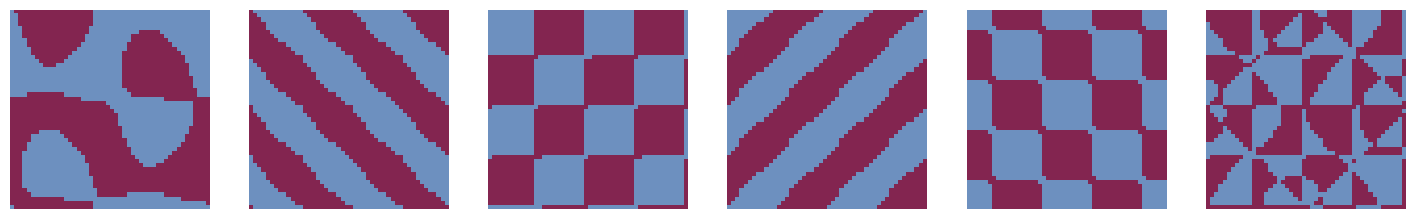

In [32]:
fig, ax = plt.subplots(1, 5+1, figsize=(18, 6))

for i in range(len(ax)-1):
    ax[i].imshow(l2d.get_eigV_bin_check(i+20).reshape(*l2d.syshape), cmap=credcblu)
    ax[i].axis('off')
ax[len(ax)-1].imshow(rand_comp.reshape(*l2d.syshape), cmap=credcblu)
ax[len(ax)-1].axis('off')

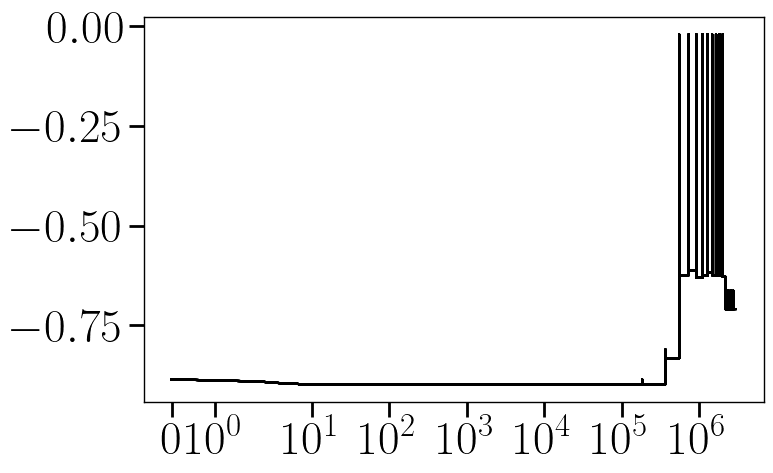

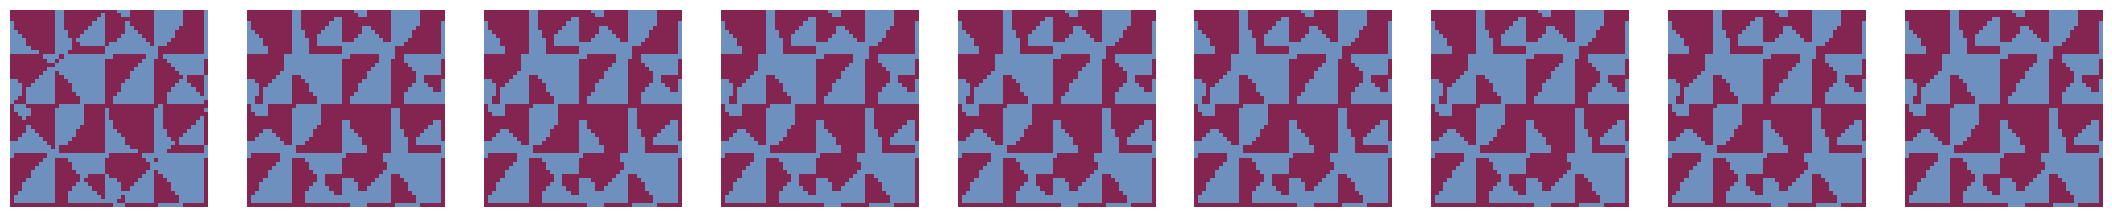

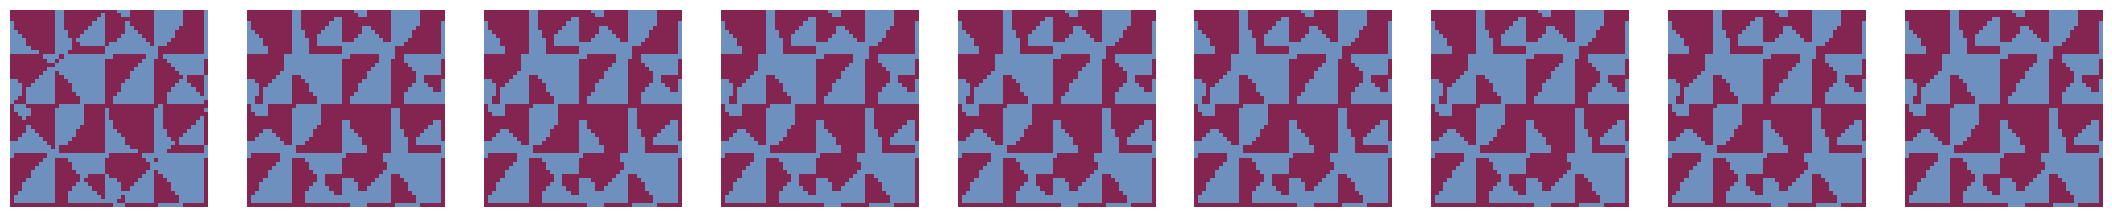

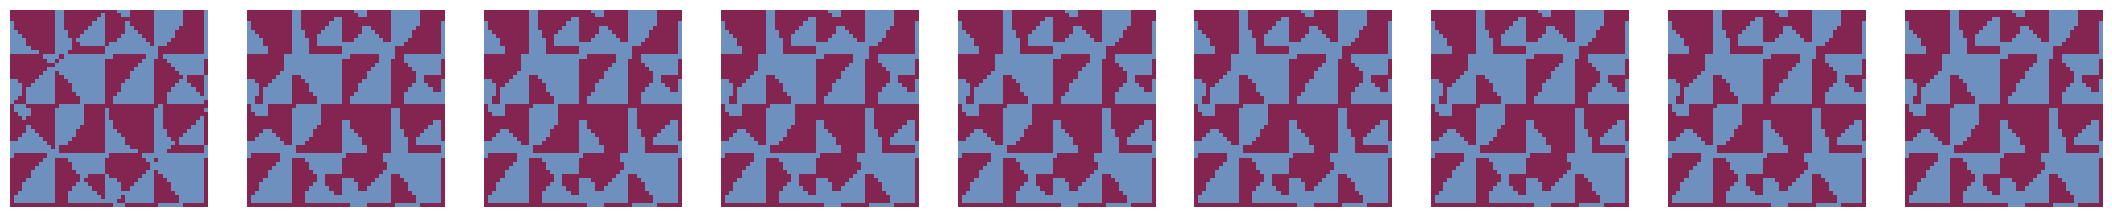

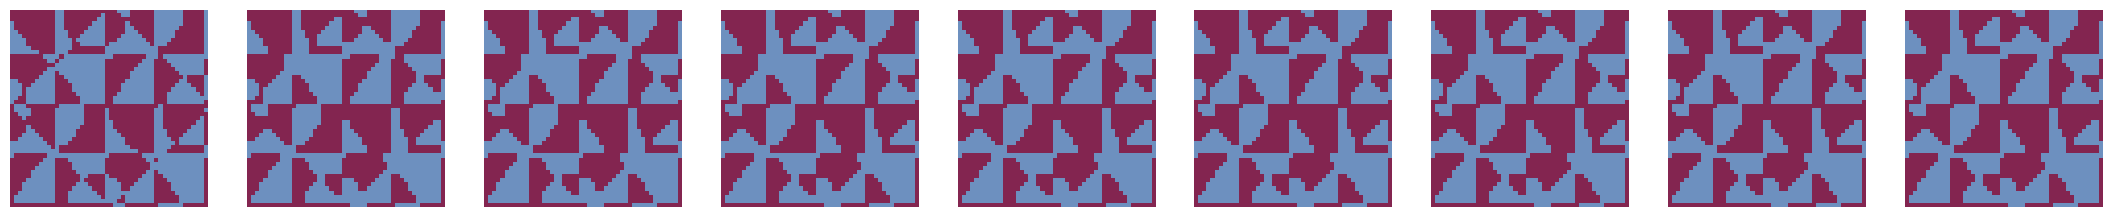

In [33]:
fig_ene, ax_ene = plt.subplots(figsize=(8, 5))
for _ in range(4):
    fname = lambda who: Path(f"{who}_p={pflip:.3g}_T={T:.3g}__{ic}_{cell}.bin")
    pname_ene = l2d.path_ising / fname("ene")
    pname_sout = l2d.path_ising / fname("sout")
    #
    isdy = IsingDynamics(l2d, T=T, ic=ic, runlang='C5', thrmSTEP=80, out_suffix=f"{ic}_{cell}")
    isdy.init_ising_dynamics(custom=rand_comp)
    isdy.run()
    #
    s_out = np.fromfile(pname_sout, dtype=np.int8).reshape(-1, *l2d.syshape)
    ene = np.fromfile(pname_ene, dtype=np.float64)

    fig, ax = plt.subplots(1, len(s_out), figsize=(3*len(s_out), 3))
    for i, s in enumerate(s_out):
        ax[i].imshow(s, cmap=credcblu)
        ax[i].axis('off')
        ax_ene.plot(np.arange(len(ene)), ene/4, 'k-')
ax_ene.set_xscale('symlog')

In [8]:
pname_ene, l2d.syshape

(PosixPath('data/plot/paper/suppinf/extras/isingXERR/l2d_squared/ising/N=2304/ene_p=0_T=0_custom_randXERR.bin'),
 (48, 48))

In [ ]:
fig, ax = plt.subplots(1, len(s_out)//2, figsize=(3*len(s_out)//2, 3))
for i, s in enumerate(s_out[::2]):
    ax[i].imshow(s, cmap=credcblu)
    ax[i].axis('off')

In [ ]:
ax.plot(np.arange(len(ene)), ene/4, 'k-')
ax.set_xscale('symlog')